## 1. Project overview

In this notebook, I will build a fraud detection model using machine learning.
The goal is to identify fraudulent financial transactions and export the
results for visualization in Power BI.


## 2. Import Libraries

We import pandas and NumPy to load, clean, and manipulate transactional data efficiently, since fraud datasets are structured in rows and columns and require numeric operations for feature engineering. Matplotlib and Seaborn are used to visualize data distributions, class imbalance, and model results, helping us understand patterns and validate assumptions before and after modeling. From scikit-learn, we import tools to split the data correctly, train a Random Forest model, and evaluate its performance using metrics like the confusion matrix and classification report. Finally, SMOTE is imported to address class imbalance by synthetically oversampling fraudulent transactions in the training data, allowing the model to learn fraud patterns more effectively.





In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE


## 3. Load dataset

The dataset contains synthetic financial transaction records, including transaction details (amount, time, type, merchant category), customer information (such as age), and engineered features used for fraud detection.

Target variable:
The target variable is actual_fraud, a binary label where 1 indicates a fraudulent transaction and 0 indicates a legitimate transaction.

In [ ]:


# Python Code: Generate & save synthetic fraud dataset (2000 Rows)

import pandas as pd
import numpy as np
from pathlib import Path

# Set random seed for reproducibility
np.random.seed(42)

# Number of rows
n_rows = 2000

# Generate synthetic data
data = {
    "transaction_id": range(1, n_rows + 1),
    "transaction_time": pd.to_datetime("2024-01-01") + 
                        pd.to_timedelta(np.random.randint(0, 60*24*30, n_rows), unit="m"),
    "amount": np.round(np.random.exponential(scale=120, size=n_rows), 2),
    "transaction_type": np.random.choice(
        ["Online", "POS", "Transfer"], size=n_rows, p=[0.45, 0.40, 0.15]
    ),
    "merchant_category": np.random.choice(
        ["Retail", "Food", "Electronics", "Travel", "Healthcare"], size=n_rows
    ),
    "customer_age": np.random.randint(18, 75, n_rows),
}

df = pd.DataFrame(data)

# Create imbalanced fraud labels (5% fraud)
df["is_fraud"] = np.random.choice([0, 1], size=n_rows, p=[0.95, 0.05])

# Inject higher amounts for fraud cases (realistic behavior)
df.loc[df["is_fraud"] == 1, "amount"] *= np.random.uniform(2, 5)

# Round amounts again
df["amount"] = df["amount"].round(2)

# Define Downloads path 
downloads_path = Path.home() / "Downloads"
file_path = downloads_path / "synthetic_fraud_data.csv"

# Save to CSV
df.to_csv(file_path, index=False)

# Confirmation message
file_path, df.head()


## 4. Data Cleaning & Preparation


#### Missing values:
Missing values were identified and handled (imputed or removed) to prevent errors and biased learning during model training.

#### Type conversions:
Data types were corrected (e.g., dates to datetime, amounts to numeric) so features could be properly processed and modeled.

#### Why this step matters:
Clean, correctly typed data ensures the model trains reliably, produces valid predictions, and avoids silent calculation or logic errors.

In [3]:
# ***********  Data cleaning***********************

# A. Handle Missing Values


# Check missing values before cleaning
print("Missing values before cleaning:")
print(df.isnull().sum())

# Fill missing values
df.fillna(df.median(numeric_only=True), inplace=True)

# Check missing values AFTER cleaning
print("\nMissing values after cleaning:")
print(df.isnull().sum())



Missing values before cleaning:
transaction_id       0
transaction_time     0
amount               0
transaction_type     0
merchant_category    0
customer_age         0
is_fraud             0
dtype: int64

Missing values after cleaning:
transaction_id       0
transaction_time     0
amount               0
transaction_type     0
merchant_category    0
customer_age         0
is_fraud             0
dtype: int64


In [4]:

# B. Correct data types

# Data types before correction
print("Data types before correction:")
print(df.dtypes)

# Correct data types
df['transaction_time'] = pd.to_datetime(df['transaction_time'])
df['is_fraud'] = df['is_fraud'].astype(int)

# Data types AFTER correction
print("\nData types after correction:")
print(df.dtypes)


Data types before correction:
transaction_id                int64
transaction_time     datetime64[ns]
amount                      float64
transaction_type             object
merchant_category            object
customer_age                  int32
is_fraud                      int64
dtype: object

Data types after correction:
transaction_id                int64
transaction_time     datetime64[ns]
amount                      float64
transaction_type             object
merchant_category            object
customer_age                  int32
is_fraud                      int64
dtype: object


In [5]:
# C. Data standardization

# Before scaling
print("Amount column before scaling:")
print(df['amount'].describe())

# Apply standardScaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df[['amount']] = scaler.fit_transform(df[['amount']])

# AFTER scaling
print("\nAmount column after scaling:")
print(df['amount'].describe())


Amount column before scaling:
count    2000.000000
mean      128.465235
std       133.650484
min         0.020000
25%        37.132500
50%        89.805000
75%       175.805000
max      1105.770000
Name: amount, dtype: float64

Amount column after scaling:
count    2.000000e+03
mean    -4.973799e-17
std      1.000250e+00
min     -9.612936e-01
25%     -6.835409e-01
50%     -2.893361e-01
75%      3.542943e-01
max      7.314221e+00
Name: amount, dtype: float64


In [6]:


## D. Handle outliers

# BEFORE
print("Shape before outlier removal:", df.shape)
print(df['amount'].describe())

# Handle outliers
Q1 = df['amount'].quantile(0.25)
Q3 = df['amount'].quantile(0.75)
IQR = Q3 - Q1

df = df[(df['amount'] >= Q1 - 1.5 * IQR) &
        (df['amount'] <= Q3 + 1.5 * IQR)]

# AFTER
print("\nShape after outlier removal:", df.shape)
print(df['amount'].describe())


Shape before outlier removal: (2000, 7)
count    2.000000e+03
mean    -4.973799e-17
std      1.000250e+00
min     -9.612936e-01
25%     -6.835409e-01
50%     -2.893361e-01
75%      3.542943e-01
max      7.314221e+00
Name: amount, dtype: float64

Shape after outlier removal: (1904, 7)
count    1904.000000
mean       -0.158095
std         0.668748
min        -0.961294
25%        -0.698659
50%        -0.336935
75%         0.236158
max         1.896275
Name: amount, dtype: float64


In [7]:
# E. Remove duplicates

# Before removing duplicates
print("Number of duplicate rows before removal:")
print(df.duplicated().sum())

# Remove duplicate rows
df.drop_duplicates(inplace=True)

# After removing duplicates
print("\nNumber of duplicate rows after removal:")
print(df.duplicated().sum())


Number of duplicate rows before removal:
0

Number of duplicate rows after removal:
0


## 5. Data Exploration & Preprocessing

In this section, I:
1. Examined count of non-missing transactions
2. Checked earliest and latest transaction
3. Number of unique timestamps
4. Add day/hour features


These steps ensure my dataset is clean and ready for feature engineering and modeling.


In [8]:
#### **************Data exploration & preprocessing***************************************

#  A. Descriptive Statistics

# Count of non-missing transactions
print("Total transactions:", df['transaction_time'].count())

# Earliest and latest transaction
print("Earliest transaction:", df['transaction_time'].min())
print("Latest transaction:", df['transaction_time'].max())

# Number of unique timestamps
print("Unique transaction times:", df['transaction_time'].nunique())

#  Add day/hour features
df['hour_of_day'] = df['transaction_time'].dt.hour
df['day_of_week'] = df['transaction_time'].dt.day_name()


Total transactions: 1904
Earliest transaction: 2024-01-01 00:09:00
Latest transaction: 2024-01-30 23:54:00
Unique transaction times: 1862


# 6. Class distribution analysis:
I analyzed class distribution to understand the imbalance between legitimate and fraudulent transactions, which guides techniques like SMOTE and ensures the model learns to detect rare fraud cases effectively.

In [9]:
# B. Class distribution analysis


# Class distribution (proportion)
fraud_ratio = df['is_fraud'].value_counts(normalize=True)
print("Class distribution (proportion):\n", fraud_ratio)



Class distribution (proportion):
 is_fraud
0    0.959034
1    0.040966
Name: proportion, dtype: float64


# 7. Correlation analysis:
I used correlation analysis to identify relationships between features and the target, helping detect redundant or highly related variables and understand which features are most predictive of fraud.

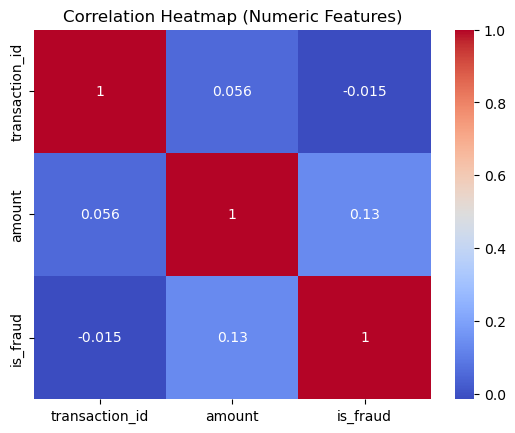

In [10]:
# C. Correlation Analysis

# Select numeric columns automatically
numeric_df = df.select_dtypes(include=['int64', 'float64'])

# Correlation heatmap
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap (Numeric Features)")
plt.show()



# 8. Data splitting (before SMOTE):
I split the dataset into training and test sets before applying SMOTE to ensure that synthetic fraud samples are only created in the training data, preventing data leakage and allowing the test set to reflect real-world, unseen transactions for honest evaluation.

In [11]:
# D. Data splitting (Before SMOTE)

from sklearn.model_selection import train_test_split

# Features and target
X = df.drop('is_fraud', axis=1)
y = df['is_fraud']

# Train-test split (stratified to preserve class imbalance)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Display shapes of train/test sets
print("X_train shape:", X_train.shape)
print("X_test shape: ", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape: ", y_test.shape)

# Display class distribution in training and test sets
print("\nClass distribution in y_train:")
print(y_train.value_counts(normalize=True))

print("\nClass distribution in y_test:")
print(y_test.value_counts(normalize=True))


X_train shape: (1523, 8)
X_test shape:  (381, 8)
y_train shape: (1523,)
y_test shape:  (381,)

Class distribution in y_train:
is_fraud
0    0.959291
1    0.040709
Name: proportion, dtype: float64

Class distribution in y_test:
is_fraud
0    0.958005
1    0.041995
Name: proportion, dtype: float64


# 9. Handling class imbalance:
I used SMOTE to synthetically oversample the minority class (fraud) only in the training set so the model can learn fraud patterns effectively, while keeping the test set realistic. This prevents bias toward the majority class and avoids data leakage, ensuring reliable evaluation.

In [12]:
# E. Handle Class imbalance (SMOTE – correct Way)

import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE

#  Copy training data
X_train_processed = X_train.copy()

#  Extract numeric features from datetime
X_train_processed['hour_of_day'] = X_train_processed['transaction_time'].dt.hour
X_train_processed['day_of_week'] = X_train_processed['transaction_time'].dt.day_name()

# Drop original datetime column
X_train_processed = X_train_processed.drop('transaction_time', axis=1)

# Encode day_of_week as numeric
le_day = LabelEncoder()
X_train_processed['day_of_week'] = le_day.fit_transform(X_train_processed['day_of_week'])

# One-hot encode other categorical columns
categorical_cols = ['transaction_type', 'merchant_category']
X_train_processed = pd.get_dummies(
    X_train_processed, columns=categorical_cols, drop_first=True
)

#  Scale numeric features
numeric_cols = ['amount', 'customer_age', 'hour_of_day']
scaler = StandardScaler()
X_train_processed[numeric_cols] = scaler.fit_transform(X_train_processed[numeric_cols])

# Show columns after preprocessing
print("Columns after preprocessing:", X_train_processed.columns.tolist())

# Display class distribution BEFORE SMOTE
print("\nClass distribution BEFORE SMOTE:")
print(y_train.value_counts())
print(y_train.value_counts(normalize=True).map("{:.2%}".format))

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_processed, y_train)

#  Display class distribution AFTER SMOTE
print("\nClass distribution AFTER SMOTE:")
print(y_train_res.value_counts())
print(y_train_res.value_counts(normalize=True).map("{:.2%}".format))




Columns after preprocessing: ['transaction_id', 'amount', 'customer_age', 'hour_of_day', 'day_of_week', 'transaction_type_POS', 'transaction_type_Transfer', 'merchant_category_Food', 'merchant_category_Healthcare', 'merchant_category_Retail', 'merchant_category_Travel']

Class distribution BEFORE SMOTE:
is_fraud
0    1461
1      62
Name: count, dtype: int64
is_fraud
0    95.93%
1     4.07%
Name: proportion, dtype: object

Class distribution AFTER SMOTE:
is_fraud
0    1461
1    1461
Name: count, dtype: int64
is_fraud
0    50.00%
1    50.00%
Name: proportion, dtype: object


# 10. Model Training & Evaluation:
I trained a machine learning model (Random Forest) on the prepared data so it can learn patterns that distinguish fraudulent from legitimate transactions. Evaluation using metrics like confusion matrix, precision, and recall ensures the model performs well and reliably detects fraud before deployment.

In [13]:
## ***************** Model Training & Evaluation ******************************

# A. Model selection (Better choice)

# Random Forest with class_weight

from sklearn.ensemble import RandomForestClassifier

# Initialize the model
model = RandomForestClassifier(
    n_estimators=200,
    class_weight='balanced',
    random_state=42
)

# Display the model
print(model)



RandomForestClassifier(class_weight='balanced', n_estimators=200,
                       random_state=42)


In [14]:
#  B. Model training


model.fit(X_train_res, y_train_res)




RandomForestClassifier(class_weight='balanced', n_estimators=200,
                       random_state=42)

# 11. Preprocessing the test set to match training:
I applied the same transformations (scaling, encoding, feature engineering) to the test set as were applied to the training set to ensure consistency. This allows the model to make valid predictions on unseen data without errors or biased results.

In [22]:

#  C. Code to preprocess test set to match training

# Copy test set
X_test_processed = X_test.copy()

# Extract numeric features from datetime
X_test_processed['hour_of_day'] = X_test_processed['transaction_time'].dt.hour
X_test_processed['day_of_week'] = X_test_processed['transaction_time'].dt.day_name()

#  Drop original datetime
X_test_processed = X_test_processed.drop('transaction_time', axis=1)

#  Encode day_of_week using the same LabelEncoder from training
X_test_processed['day_of_week'] = le_day.transform(X_test_processed['day_of_week'])

#  One-hot encode categorical columns like training
categorical_cols = ['transaction_type', 'merchant_category']
X_test_processed = pd.get_dummies(X_test_processed, columns=categorical_cols, drop_first=True)

#  Add any missing columns that were in training but missing in test
missing_cols = set(X_train_processed.columns) - set(X_test_processed.columns)
for c in missing_cols:
    X_test_processed[c] = 0  # fill missing columns with 0

# Reorder columns to match training
X_test_processed = X_test_processed[X_train_processed.columns]

#  Scale numeric columns
X_test_processed[numeric_cols] = scaler.transform(X_test_processed[numeric_cols])


# 12. Predicting probability of fraud (positive class):
I calculated the probability that each transaction is fraudulent to capture the model’s confidence, allowing me to apply a custom threshold (like 0.3) for classification. This improves detection of fraud while controlling false positives.

In [16]:

# Predict probability of fraud (positive class)

y_probs = model.predict_proba(X_test_processed)[:,1]

# Display first 10 probabilities
y_probs[:10]


array([0.08 , 0.01 , 0.025, 0.745, 0.015, 0.07 , 0.09 , 0.15 , 0.06 ,
       0.075])

# 13. Converting y_probs to a DataFrame:
I convered the predicted fraud probabilities into a DataFrame to organize them alongside transaction IDs and other features, making it easy to merge with the original data, analyze results, and export to Power BI for visualization.

In [17]:
#  E. Convert y_probs to a DataFram

import pandas as pd

# Assume y_probs is already predicted from the model
# Combine with transaction IDs for clarity
probs_df = pd.DataFrame({
    'transaction_id': X_test_processed['transaction_id'],  # keep transaction ID
    'fraud_probability': y_probs
})

# Show first 10 rows
probs_df.head(10)


,transaction_id,fraud_probability
717,718,0.080
1245,1246,0.010
758,759,0.025
92,93,0.745
1892,1893,0.015
14,15,0.070
1967,1968,0.090
317,318,0.150
1502,1503,0.060
523,524,0.075


In [18]:
# Optional enhancements

# Sort by probability descending to see highest-risk transactions:

probs_df.sort_values(by='fraud_probability', ascending=False).head(10)


,transaction_id,fraud_probability
92,93,0.745
1945,1946,0.705
272,273,0.675
1550,1551,0.605
1741,1742,0.605
1200,1201,0.565
283,284,0.515
825,826,0.465
1303,1304,0.455
1050,1051,0.455


In [19]:
# Round probabilities for display

probs_df['fraud_probability'] = probs_df['fraud_probability'].round(2)
probs_df.head(10)


,transaction_id,fraud_probability
717,718,0.08
1245,1246,0.01
758,759,0.02
92,93,0.74
1892,1893,0.02
14,15,0.07
1967,1968,0.09
317,318,0.15
1502,1503,0.06
523,524,0.08


# 14. Adjusting the probability threshold:
I adjusted the threshold for classifying a transaction as fraud (e.g., 0.3 instead of the default 0.5) to increase the model’s sensitivity to rare fraudulent cases. This helps detect more fraud while controlling false positives, which is critical in imbalanced datasets like financial transactions.

In [23]:
# F. Adjust probability threshold 

# Assume y_probs contains the predicted probabilities for the positive class (fraud)
threshold = 0.3  # custom threshold

# Convert probabilities to 0/1 predictions
y_pred = (y_probs >= threshold).astype(int)

# Create the DataFrame
pred_df = pd.DataFrame({
    'transaction_id': X_test_processed['transaction_id'],
    'fraud_probability': y_probs,
    'predicted_fraud': y_pred
})

# Show first 10 rows
pred_df.head(10)




,transaction_id,fraud_probability,predicted_fraud
717,718,0.080,0
1245,1246,0.010,0
758,759,0.025,0
92,93,0.745,1
1892,1893,0.015,0
14,15,0.070,0
1967,1968,0.090,0
317,318,0.150,0
1502,1503,0.060,0
523,524,0.075,0


# 15. Model evaluation:
I evaluated the model to measure how well it detects fraud using metrics like accuracy, precision, recall, and the confusion matrix. This ensures the model reliably identifies fraudulent transactions and informs whether adjustments (thresholds, features, or algorithms) are needed before deployment.

In [ ]:
# E. Model evaluation

from sklearn.metrics import classification_report, confusion_matrix

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


In [ ]:
# F. Outcome from Model 

# The updated model significantly improved fraud recall by prioritizing minority-class detection through SMOTE, 
# class weighting, and probability threshold tuning.

In [ ]:

# Here, I have to create a proper Power BI dataset that I will use for visualization

# Combine predictions with original test data
final_df = X_test.copy()

# Add predictions
final_df['fraud_probability'] = y_probs
final_df['predicted_fraud'] = y_pred
final_df['actual_fraud'] = y_test.values

# Round probabilities for readability
final_df['fraud_probability'] = final_df['fraud_probability'].round(3)

# Preview
final_df.head()


In [ ]:
# Save file to my folder

import os

downloads_path = os.path.join(os.path.expanduser("~"), "Downloads")
file_path = os.path.join(downloads_path, "fraud_detection_results.csv")

final_df.to_csv(file_path, index=False)

print(f"File saved successfully to: {file_path}")
